## Import required modules

In [8]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import matplotlib.pyplot as plt

%matplotlib inline

## Load and prepare the data

In [3]:
df = pd.read_csv('csv_mqtt/encoded_finalset.csv')
df = shuffle(df,random_state=10)
df.groupby(['target']).size()

target
0    949302
1    165463
dtype: int64

In [5]:
df_sample = df.sample(frac=0.10)
df_sample.groupby(['target']).size()

target
0    94873
1    16603
dtype: int64

In [6]:
x_columns = df_sample.columns.drop('target')
x = df_sample[x_columns].values
y = df_sample.target
x.shape

(111476, 58)

In [9]:
from sklearn.model_selection import train_test_split
print("Ready to generate train and test datasets")
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1,shuffle=True, random_state=7)
print("x_train, y_train, x_test, y_test" + str(x_train.shape) + "" +str(y_train.shape) + "" +str(x_test.shape) + "" +str(y_test.shape))

Ready to generate train and test datasets
x_train, y_train, x_test, y_test(100328, 58)(100328,)(11148, 58)(11148,)


## training the model with different training rate

In [11]:
import time
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    start =  time.time()
    gb = GradientBoostingClassifier(learning_rate = learning_rate)
    gb.fit(x_train, y_train)
    end =  time.time()
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(x_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(x_test, y_test)))
    print("Time (validation): {0:.3f}".format(end-start))
    print()


Learning rate:  0.05
Accuracy score (training): 0.983
Accuracy score (validation): 0.983
Time (validation): 22.409

Learning rate:  0.1
Accuracy score (training): 0.983
Accuracy score (validation): 0.984
Time (validation): 22.364

Learning rate:  0.25
Accuracy score (training): 0.984
Accuracy score (validation): 0.984
Time (validation): 22.293

Learning rate:  0.5
Accuracy score (training): 0.984
Accuracy score (validation): 0.984
Time (validation): 22.260

Learning rate:  0.75
Accuracy score (training): 0.984
Accuracy score (validation): 0.984
Time (validation): 22.571

Learning rate:  1
Accuracy score (training): 0.984
Accuracy score (validation): 0.984
Time (validation): 22.450



## Determine important features

In [12]:
print(gb.feature_importances_)

[4.03244036e-01 4.46911505e-01 0.00000000e+00 1.93280690e-02
 8.26775237e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.28461929e-04 9.49775638e-03
 7.00721580e-04 3.47362372e-02 0.00000000e+00 2.76648122e-06
 2.56695168e-06 8.26297027e-06 1.70510907e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 8.71692268e-03 0.00000000e+00 0.00000000e+00
 3.38663567e-05 0.00000000e+00 9.72480547e-09 1.05203138e-02
 1.47575623e-06 0.00000000e+00 0.00000000e+00 5.30083597e-03
 6.54046265e-12 3.71125259e-05 9.57450639e-06 0.00000000e+00
 1.00780067e-02 0.00000000e+00 3.20464171e-07 2.86450371e-10
 1.45113072e-08 6.78642796e-03 6.62779952e-04 2.35891025e-02
 1.93830987e-02 3.01875936e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


<AxesSubplot:>

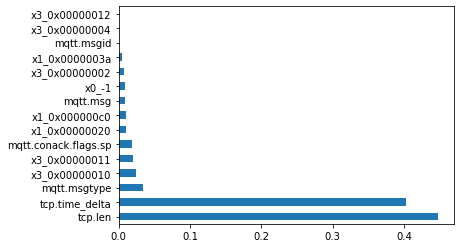

In [32]:
# plot
(pd.Series(gb.feature_importances_, index=df_sample.columns[:-1])
   .nlargest(15)
   .plot(kind='barh')) 

## Hyperparameters tuning

### Tree specific hyperparameters
max_depth,
min_samples_split,
min_samples_leaf,
max_features,
max_leaf_nodes

### Other Parameters
n_estimators (number of trees),
learning_rate,
subsample,

In [34]:
p_test3 = {'learning_rate':[0.2,0.1,0.05,0.01], 'n_estimators':[100,250,500,750,1000,1500]}

tuning = GridSearchCV(estimator =GradientBoostingClassifier(max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10), 
            param_grid = p_test3, scoring='accuracy',n_jobs=4, cv=5)
tuning.fit(x_train,y_train)
tuning.grid_scores_, tuning.best_params_, tuning.best_score_

AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

In [36]:
tuning.best_params_, tuning.best_score_

({'learning_rate': 0.05, 'n_estimators': 750}, 0.9835738757837984)

In [38]:
p_test2 = {'max_depth':[2,3,4,5,6,7] }
tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.05,n_estimators=750, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10), 
            param_grid = p_test2, scoring='accuracy',n_jobs=4, cv=5)
tuning.fit(x_train,y_train)
tuning.best_params_, tuning.best_score_

({'max_depth': 4}, 0.9835738757837984)

## Testing on the full data set

In [39]:
x_columns = df.columns.drop('target')
x = df[x_columns].values
y = df.target
x.shape

(1114765, 58)

In [40]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1,shuffle=True, random_state=7)
print("x_train, y_train, x_test, y_test" + str(x_train.shape) + "" +str(y_train.shape) + "" +str(x_test.shape) + "" +str(y_test.shape))

x_train, y_train, x_test, y_test(1003288, 58)(1003288,)(111477, 58)(111477,)


In [49]:

start =  time.time()
gb = GradientBoostingClassifier(learning_rate=0.05,n_estimators=750, max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10)
gb.fit(x_train, y_train)
end =  time.time()
print("Learning rate: ", learning_rate)
print("Accuracy score (training): {0:.3f}".format(gb.score(x_train, y_train)))
print("Accuracy score (validation): {0:.3f}".format(gb.score(x_test, y_test)))
print("Time (validation): {0:.3f}".format(end-start))
print()


Learning rate:  1
Accuracy score (training): 0.984
Accuracy score (validation): 0.983
Time (validation): 583.759



Confusion matrix, without normalization
[[94631   317]
 [ 1537 14992]]


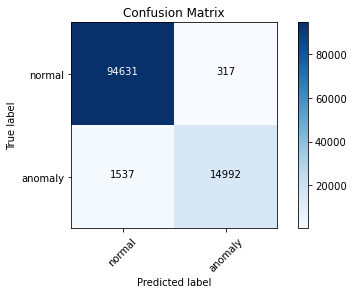

In [56]:
cm = confusion_matrix(y_true=y_test, y_pred=predictions)
cm_plot_labels = ['normal','anomaly']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

Confusion matrix, without normalization
[[0.99666133 0.00333867]
 [0.09298808 0.90701192]]


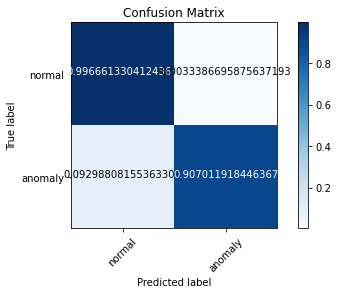

In [58]:
cm = confusion_matrix(y_true=y_test, y_pred=predictions, normalize = 'true')
cm_plot_labels = ['normal','anomaly']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')